In [1]:
# Восьмая нейросеть. Передача обучения

# Импорт библиотек
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [2]:
# Загрузка набора данных с цветами из tensorflow_datasets
splits = ['train[:70%]', 'train[-30%:]']
(training_set, validation_set), dataset_info = tfds.load('tf_flowers', with_info=True, as_supervised=True, split=splits)

In [3]:
# Вывод метадаты и информации о классах в наборе

num_classes = dataset_info.features['label'].num_classes
num_training_examples = 0
num_validation_examples = 0

for example in training_set:
    num_training_examples += 1

for example in validation_set:
    num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))


Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [4]:
# Изображения цветов в датасете цветов
for i, example in enumerate(training_set.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

IMAGE_RES = 224 # Размер выходного изображения

# Функция для преобразования размера изображений
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

BATCH_SIZE = 32

# Создание наборов данных
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [5]:
# Получение свойств модели (вектора свойств)
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
feature_extractor.trainable = False

In [6]:
# Создание модели
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes, activation='softmax')
])

# Вывод информации о модели
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [7]:
# Компиляция модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 6 # Количество прогонов обучения

# Обучение модели
history = model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 7s 83ms/step - loss: 0.7536 - accuracy: 0.7225 - val_loss: 0.4441 - val_accuracy: 0.8456
Epoch 2/6
81/81 [==============================] - 6s 75ms/step - loss: 0.3806 - accuracy: 0.8750 - val_loss: 0.3682 - val_accuracy: 0.8810
Epoch 3/6
81/81 [==============================] - 6s 75ms/step - loss: 0.2984 - accuracy: 0.9039 - val_loss: 0.3253 - val_accuracy: 0.8910
Epoch 4/6
81/81 [==============================] - 6s 77ms/step - loss: 0.2507 - accuracy: 0.9225 - val_loss: 0.3034 - val_accuracy: 0.8955
Epoch 5/6
81/81 [==============================] - 6s 75ms/step - loss: 0.2198 - accuracy: 0.9358 - val_loss: 0.3001 - val_accuracy: 0.8965
Epoch 6/6
81/81 [==============================] - 6s 75ms/step - loss: 0.1882 - accuracy: 0.9463 - val_loss: 0.2825 - val_accuracy: 0.9055


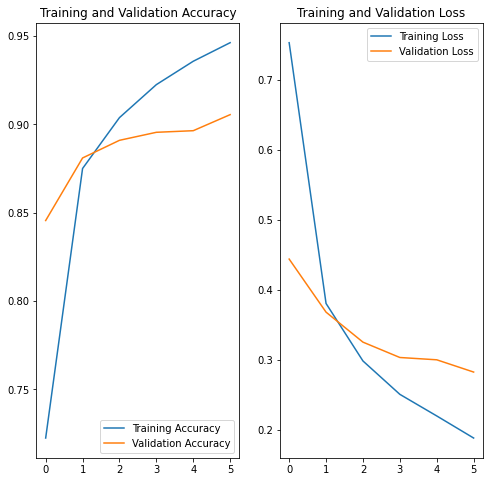

In [8]:
# Построение графиков точности и потерь
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
# Создание классов цветов
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [10]:
# Вывод информации о цветах, в том числе их labels
image_batch, label_batch = next(iter(train_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

# Вывод правильных и неправильных значений
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

['dandelion' 'daisy' 'roses' 'daisy' 'dandelion' 'daisy' 'tulips'
 'dandelion' 'sunflowers' 'daisy' 'daisy' 'dandelion' 'sunflowers'
 'dandelion' 'dandelion' 'daisy' 'daisy' 'tulips' 'dandelion' 'sunflowers'
 'daisy' 'dandelion' 'roses' 'dandelion' 'roses' 'daisy' 'dandelion'
 'dandelion' 'roses' 'roses' 'sunflowers' 'daisy']
Labels:            [3 1 4 1 0 1 2 0 3 1 1 0 3 0 0 1 1 2 0 3 1 0 4 0 2 1 0 0 4 4 3 1]
Predicted labels:  [0 1 4 1 0 1 2 0 3 1 1 0 3 0 0 1 1 2 0 3 1 0 4 0 4 1 0 0 4 4 3 1]


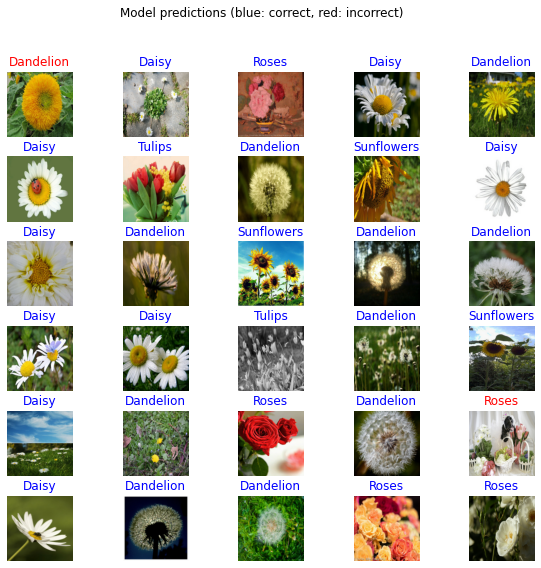

In [11]:
# Построение таблицы изображений из тестового набора
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [12]:
# Для загрузки файла
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array
files.upload()

Saving 3609.jpg to 3609 (2).jpg


{'3609.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xe1\x00"Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x01\x01\x12\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x02\x01\x01\x02\x02\x02\x02\x02\x02\x02\x02\x03\x05\x03\x03\x03\x03\x03\x06\x04\x04\x03\x05\x07\x06\x07\x07\x07\x06\x07\x07\x08\t\x0b\t\x08\x08\n\x08\x07\x07\n\r\n\n\x0b\x0c\x0c\x0c\x0c\x07\t\x0e\x0f\r\x0c\x0e\x0b\x0c\x0c\x0c\xff\xdb\x00C\x01\x02\x02\x02\x03\x03\x03\x06\x03\x03\x06\x0c\x08\x07\x08\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\xff\xc0\x00\x11\x08\x02]\x03[\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01

Text(0.5, 1.0, 'roses')

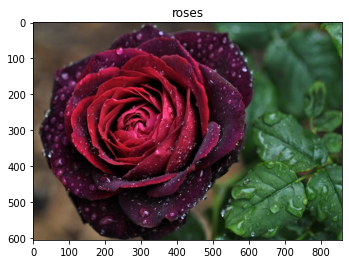

In [13]:
# Функция, уменьшающая изображение
def resize_image(img, label):
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (IMAGE_RES, IMAGE_RES))
    img = img / 255.0
    return img, label

# Вывод изображения и его класса соответственно 
img = load_img('3609.jpg')
img_array = img_to_array(img)
img_resized, _ = resize_image(img_array, _)
img_expended = np.expand_dims(img_resized, axis=0)
predict = model.predict(img_expended)
predicted_id = np.argmax(predict)
predicted_class_name = class_names[predicted_id]
plt.figure()
plt.imshow(img)
plt.title(f'{predicted_class_name}')